In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from myfunctions import set_importer, scores
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score

pd.set_option('display.max_columns', None)

sns.set_style("whitegrid")
%matplotlib inline

# setting font size for all plots
font = {'size'   : 16}

plt.rc('font', **font)

In [8]:
# import X_train_encoded, X_test_encoded, y_train and y_test
X_train = set_importer('../analysis-dfs/X_train_prepared.csv')
X_test = set_importer('../analysis-dfs/X_test_prepared.csv')

y_train = set_importer('../analysis-dfs/y_train_prepared.csv', y=True)
y_test = set_importer('../analysis-dfs/y_test_prepared.csv', y=True)

display(X_train.shape)
X_train.head(10)

(29852, 47)

,gps_height,longitude,latitude,region_code,district_code,population,permit,construction_year,basin_lake nyasa,basin_lake rukwa,basin_lake tanganyika,basin_lake victoria,basin_pangani,basin_rufiji,basin_ruvuma / southern coast,basin_wami / ruvu,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_class_surface,source_class_unknown,waterpoint_type_group_communal standpipe,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,-0.356274,1.723728,-1.640197,-0.393261,-0.194167,1.366671,0.66262,0.801349,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,-0.884573,-0.348901,-1.036569,-0.240379,0.092932,-0.675954,0.66262,-1.231119,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0
2,-0.884573,-0.267184,-1.007222,-0.240379,0.092932,-0.675954,0.66262,-1.231119,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0
3,-0.693453,1.097498,-0.507180,-0.597103,-0.385566,1.025095,0.66262,0.816731,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
4,0.993994,-0.536809,1.177516,0.167305,-0.194167,1.366671,-1.50916,0.828011,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
5,0.933395,-0.798928,1.241827,0.116345,-0.481266,2.732976,0.66262,0.815706,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
6,-0.884573,-1.349221,1.396173,0.065384,-0.385566,-0.675954,0.66262,-1.231119,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
7,-0.884573,-0.072088,1.885445,0.014424,-0.481266,-0.675954,-1.50916,-1.231119,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
8,0.736060,0.033395,-1.704817,-0.342300,-0.289867,-0.341209,0.66262,0.809553,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
9,2.404861,-0.405766,-1.092367,-0.291340,-0.289867,-0.675954,-1.50916,0.793146,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0


# Modelling

In [10]:
vanilla_logreg = LogisticRegression(solver='saga', random_state=21) # using saga because this is a very big data set
vanilla_logreg.fit(X_train, y_train)

y_preds_test = vanilla_logreg.predict(X_test)
y_probs_test = vanilla_logreg.predict_proba(X_test)[:, 1]

In [11]:
# printing the scores
print('Vanilla scores')
scores(y_test, y_preds_test, y_probs_test)

Vanilla scores
The precision score is:	 0.8636740331491712
The recall score is:	 0.9670584596350139
The accuracy score is:	 0.8426435877261998
The log loss is:	 3.2564939139587152
The auc is:	 0.5635629872969485


# Optimizing the model

## Feature Selection

Using RFECV which perform RFE in a cross-validation loop to find the best features.

In [12]:
logreg = LogisticRegression(solver='saga', random_state=21)

rfecv = RFECV(logreg, scoring='neg_log_loss')
rfecv.fit(X_train, y_train)

len(rfecv.cv_results_['mean_test_score'])

47

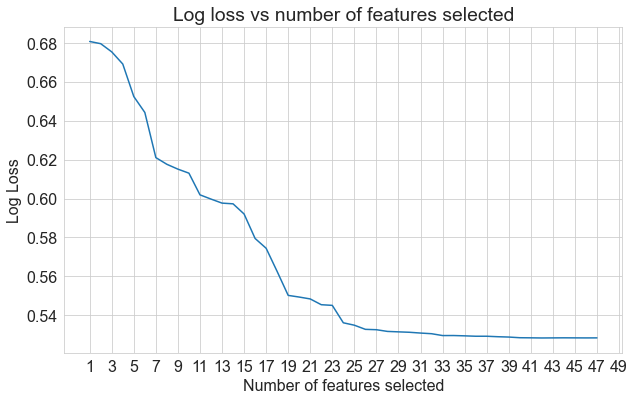

In [13]:
# plotting the results
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(rfecv.cv_results_['mean_test_score'])+1), -rfecv.cv_results_['mean_test_score'])
plt.ylabel('Log Loss')
plt.xlabel('Number of features selected')
plt.xticks(np.arange(1, 51, 2))
plt.title('Log loss vs number of features selected')
plt.show()

The log loss decrease with the increase in features. The log loss is mininum when all features are selected. Hence the vanila model is still the best

## Evaluating the Model using cross_val_score

In [14]:
cv_log_loss = cross_val_score(vanilla_logreg, X_train, y_train, cv=10, scoring='neg_log_loss')
cv_accuracy_score = cross_val_score(vanilla_logreg, X_train, y_train, cv=10, scoring='accuracy')

In [15]:
print('K-fold cross-validation results for the vanilla model')
print('The mean log loss is:\t', -cv_log_loss.mean())
print('The mean accuracy score is:\t', cv_accuracy_score.mean())

K-fold cross-validation results for the vanilla model
The mean log loss is:	 0.526322020120739
The mean accuracy score is:	 0.7459814028840339


With cross validation the vanilla model seems to be doing better even. Hence will still stick with it as been the best

## Using Grid Search I will locate the best parameters

In [16]:
#  setting up the grid parameters
param_grid = {
    'C': [1, 1e5],
    'solver': ['sag', 'saga'],
    'max_iter': [3000, 5000]
}


In [17]:
logreg = LogisticRegression(random_state=21)
logreg_gridcv = GridSearchCV(logreg, param_grid=param_grid, scoring='neg_log_loss', cv=5)
logreg_gridcv.fit(X_train, y_train)

logreg_gridcv_results = logreg_gridcv.cv_results_

In [18]:
# Displaying the parameters that lead to an optimum model
logreg_gridcv.best_params_

{'C': 1, 'max_iter': 3000, 'solver': 'sag'}

The grid search picked  paramaters {'C': 1, 'max_iter': 3000, 'solver': 'sag'} that lead to an optimum model

In [19]:
tunned_model = LogisticRegression(random_state=21, solver='sag', max_iter=3000)

tunned_model_cv_log_loss = cross_val_score(tunned_model, X_train, y_train, cv=10, scoring='neg_log_loss')
tunned_model_cv_accuracy_score = cross_val_score(tunned_model, X_train, y_train, cv=10, scoring='accuracy')

# comparing the results
print('K-fold cross-validation results for the vanilla model')
print('The mean log loss is:\t', -cv_log_loss.mean())
print('The mean accuracy score is:\t', cv_accuracy_score.mean())
print()
print('K-fold cross-validation results for the tunned model')
print('The mean log loss is:\t', -tunned_model_cv_log_loss.mean())
print('The mean accuracy score is:\t', tunned_model_cv_accuracy_score.mean())

K-fold cross-validation results for the vanilla model
The mean log loss is:	 0.526322020120739
The mean accuracy score is:	 0.7459814028840339

K-fold cross-validation results for the tunned model
The mean log loss is:	 0.5263210858530101
The mean accuracy score is:	 0.7460484045590758


The difference in the performance of the two models is low for judgement. Hence will stick with the vanilla model as the best one.

In [20]:
best_logistic_regression_model = vanilla_logreg